In [2]:
import os
import datetime
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt

import sys
sys.path.append('/home/user/thesis_ws/src/ML/UTILITIES')
from PreProcessingFunctions import myfilter, num_transient, sliding_sum_window, select_index, add_padding
from PreProcessingFunctions import WS, WS_B
from PreProcessingFunctions import rename_and_convert_to_txt

from OrganizeReports import compare_and_organize
from Performance_plotter import plot_f1_score_threshold, plot_precision_recall_curve, plot_confusion_matrix, plot_roc_curve
# from ML_models_functions import to_save_model

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report

import tensorflow

tensorflow.config.list_physical_devices('GPU')
gpus = tensorflow.config.experimental.list_physical_devices('GPU')
if gpus:    # Restrict TensorFlow to only allocate memory on the GPU dynamically
    for gpu in gpus:
        tensorflow.config.experimental.set_memory_growth(gpu, True)
    tensorflow.config.experimental.set_visible_devices(gpus[0], 'GPU')

from tensorflow.keras.models     import Sequential, Model, load_model
from tensorflow.keras.layers     import Input, Conv1D, Conv2D, BatchNormalization
from tensorflow.keras.layers     import Flatten, Dense, MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D
from tensorflow.keras.layers     import LeakyReLU, ReLU, Activation, Dropout, Lambda
from tensorflow.keras.layers     import concatenate, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses     import BinaryCrossentropy
from tensorflow.keras.metrics    import AUC, Precision, Recall
from tensorflow.keras.utils      import plot_model
from tensorflow.keras.callbacks  import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models     import save_model


folder_path = '/home/user/thesis_ws/src/RobotData_GRIPA320'
data_folder = '/home/user/thesis_ws/src/ML/DATA/1D_F_GRIP/'

2024-04-28 22:09:04.954141: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-28 22:09:05.641955: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-04-28 22:09:06.104364: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-04-28 22:09:06.104443: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: user
2024-04-28 22:09:06.104461: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:141] hostname: user
2024-04-28 22:09:06.104723: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:165] libcuda reported version is: 550.54.15
2024-04-

In [3]:
# %load_ext tensorboard
# %tensorboard --logdir TensorBoarLOGS/

In [4]:
def load_data(data_folder):
    X_data = []
    y_data = []
    # Get list of all .npz files in the data folder
    npz_files = [file for file in os.listdir(data_folder) if file.endswith('.npz')]
    
    # Load data from each .npz file
    for file in npz_files:
        file_path = os.path.join(data_folder, file)
        data = np.load(file_path)
        X_data.append(data['X'])  # Assuming X_data is stored under 'X' key in the .npz file
        y_data.append(data['y'])  # Assuming y_data is stored under 'y' key in the .npz file
        data.close()
    
    # Convert lists to NumPy arrays
    X_data = np.array(X_data)
    y_data = np.array(y_data)
    
    return X_data, y_data

# Load the data
X_data, y_data = load_data(data_folder)

# Check the shape of loaded data
print("X_data shape:", X_data.shape)
print("y_data shape:", y_data.shape)
print("X_data.[0] shape: ", X_data[0].shape)

VH_greenArrow/Butt_3N_2000_#20.csv adding, its len: (800,), Y is: 1.0
current X_data:  1 800
VH_greenArrow/Butt_1N_1600_#40.csv adding, its len: (800,), Y is: 0.0
current X_data:  2 800
VH_greenArrow/Butt_2N_1200_#45.csv adding, its len: (800,), Y is: 1.0
current X_data:  3 800
VH_greenArrow/Butt_5N_1400_#31.csv adding, its len: (800,), Y is: 1.0
current X_data:  4 800
VH_greenArrow/Butt_3N_1600_#18.csv adding, its len: (800,), Y is: 1.0
current X_data:  5 800
VH_greenArrow/Butt_1N_1800_#41.csv adding, its len: (800,), Y is: 0.0
current X_data:  6 800
VH_greenArrow/Butt_5N_1600_#32.csv adding, its len: (800,), Y is: 1.0
current X_data:  7 800
VH_greenArrow/Butt_1N_800_#35.csv adding, its len: (800,), Y is: 0.0
current X_data:  8 800
VH_greenArrow/Butt_3N_800_#14.csv adding, its len: (800,), Y is: 1.0
current X_data:  9 800
VH_greenArrow/Butt_3N_1000_#51.csv adding, its len: (800,), Y is: 1.0
current X_data:  10 800
VH_greenArrow/Butt_4N_1800_#26.csv adding, its len: (800,), Y is: 1.0
c

In [30]:
TEST_SIZE = 0.4
X_train, X_temp, y_train, y_temp = train_test_split(X_data, y_data, test_size=TEST_SIZE, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"TOTAL DATA: {len(X_data)}  ||  Train = {100*(1-TEST_SIZE)}%  ||  Test = {100*TEST_SIZE}%")
print("Dimensions of X_train:", X_train.shape, "   ||  Dimensions of y_train:", y_train.shape)
print("Dimensions of X_test: ", X_test.shape, "   ||  Dimensions of y_test: ", y_test.shape)
print("Dimensions of X_val:  ", X_val.shape, "   ||  Dimensions of y_val:  ", y_val.shape)

TOTAL DATA: 1248  ||  Train = 60.0%  ||  Test = 40.0%
Dimensions of X_train: (748, 800)    ||  Dimensions of y_train: (748,)
Dimensions of X_test:  (250, 800)    ||  Dimensions of y_test:  (250,)
Dimensions of X_val:   (250, 800)    ||  Dimensions of y_val:   (250,)


# 1 CONVs

/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_25 (Conv1D)              │ (None, 761, 128)       │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 97408)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 64)             │     6,234,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,239,489 (23.80 MB)

 Trainable params: 6,239,489 (23.80 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/4
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.5416 - loss: 6.5779 - val_accuracy: 0.5760 - val_loss: 0.7746
Epoch 2/4
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.5821 - loss: 0.7128 - val_accuracy: 0.6520 - val_loss: 0.6501
Epoch 3/4
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.6986 - loss: 0.5589 - val_accuracy: 0.6360 - val_loss: 0.6210
Epoch 4/4
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.6841 - loss: 0.5375 - val_accuracy: 0.7080 - val_loss: 0.5929
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6937 - loss: 0.7614
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


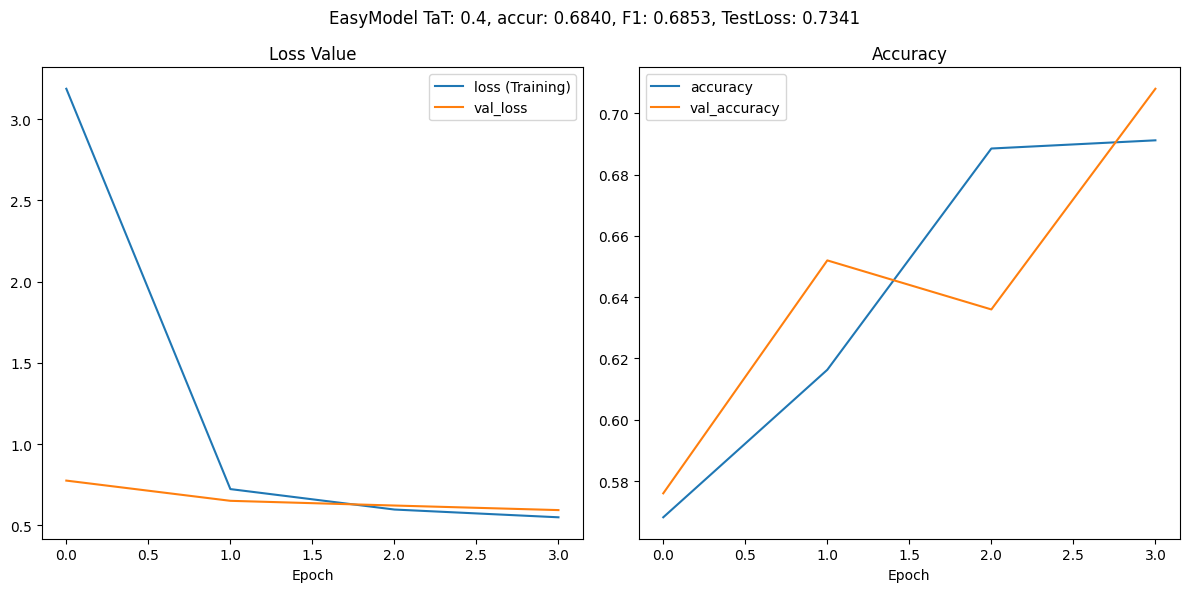

Train loss: 0.5485685467720032
Test val_loss: 0.5929247140884399
Train accuracy: 0.6911764740943909
Accuracy Score: 0.684
F1 Score: 0.6852589641434262
Classification Report:
               precision    recall  f1-score   support

         0.0       0.79      0.60      0.68       142
         1.0       0.60      0.80      0.69       108

    accuracy                           0.68       250
   macro avg       0.70      0.70      0.68       250
weighted avg       0.71      0.68      0.68       250



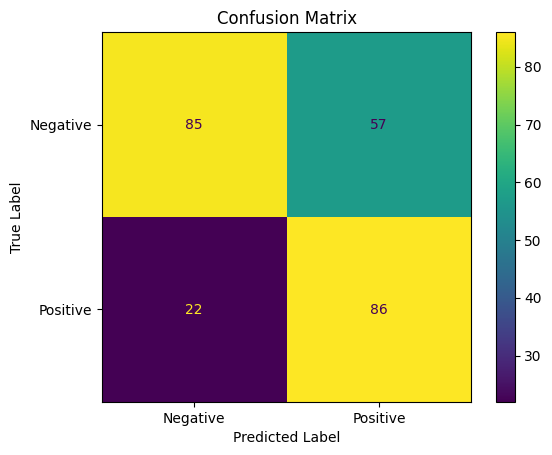

In [26]:
def build_easyModel():
    model = Sequential()
    model.add(Conv1D(filters=128, kernel_size=40, activation='relu', input_shape=(WS_B, 1)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

model_name = "1D_easy1Conv_smallKernels"
model = build_easyModel()
model.summary()
model.compile(optimizer=Adam(learning_rate=0.004), loss='binary_crossentropy', metrics=['accuracy'])

# log_dir = "logs/fit/" + f"{model_name}/"+ datetime.datetime.now().strftime("%d-%m-%y--%H:%M:%S")
# tensorboard = TensorBoard(log_dir=log_dir)
history = model.fit(X_train, y_train, epochs=4, batch_size=32, validation_data=(X_val, y_val), verbose=1) # , callbacks=[tensorboard]

loss, accuracy = model.evaluate(X_test, y_test)

# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

f1 = f1_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))

#to_save_model(model=model, history=history, loss=loss, accuracy=accuracy, f1=f1, model_name=model_name, y_test=y_test, y_pred_binary=y_pred_binary, building_function=build_easyModel)
#compare_and_organize(model_name, build_easyModel, history.history, y_test, y_pred_binary)
plot_confusion_matrix(y_test, y_pred_binary)


# <span style="color:red;"> PLOT F1 SCORE AND F1 WRT ALL the THRESHOLDS</span>


# 2 CONVs 

/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 751, 128)       │         6,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 742, 128)       │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 371, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 47488)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     3,039,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,209,857 (12.24 MB)

 Trainable params: 3,209,857 (12.24 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 0.5429 - loss: 1.7242 - val_accuracy: 0.6600 - val_loss: 0.6062
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 0.7022 - loss: 0.5637 - val_accuracy: 0.7000 - val_loss: 0.5425
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.6964 - loss: 0.5244 - val_accuracy: 0.7200 - val_loss: 0.5358
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 0.6840 - loss: 0.5830 - val_accuracy: 0.6960 - val_loss: 0.5275
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 181ms/step - accuracy: 0.7624 - loss: 0.4544 - val_accuracy: 0.6640 - val_loss: 0.5842
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 0.7290 - loss: 0.4887 - val_accuracy: 0.7200 - val_loss: 0.6112
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.7934 - loss: 0.3978 - val_accuracy: 0.7360 - val_loss: 0.5161
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.8330 - loss: 0.3503 - val_accuracy: 0.

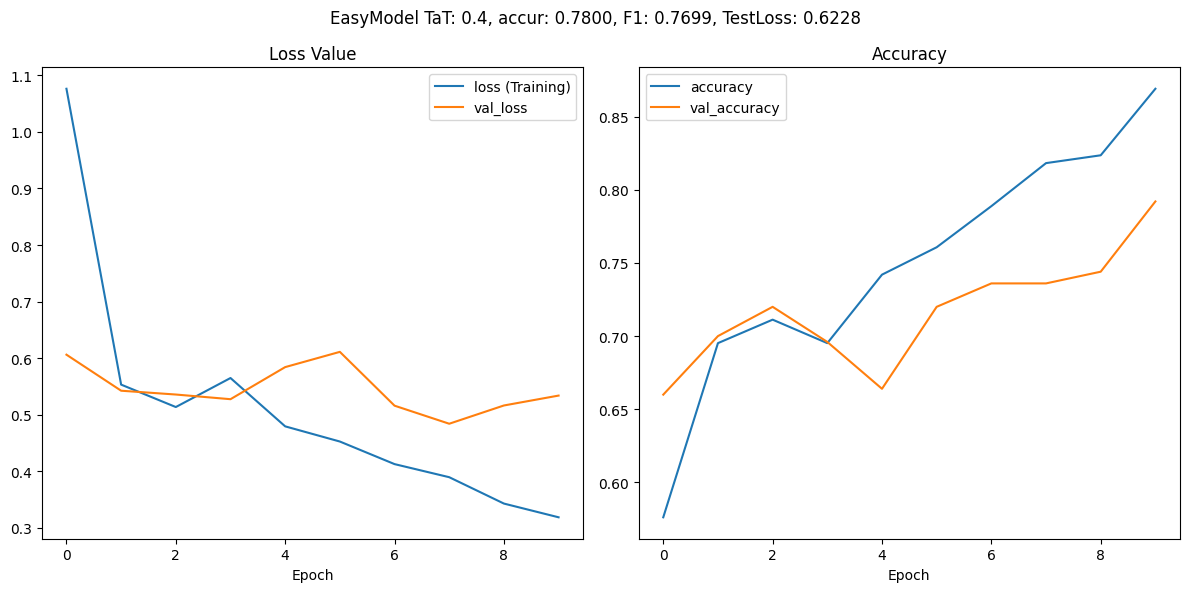

Train loss: 0.31874147057533264
Test val_loss: 0.5339059233665466
Train accuracy: 0.8689839839935303
Accuracy Score: 0.78
F1 Score: 0.7698744769874477
Classification Report:
               precision    recall  f1-score   support

         0.0       0.87      0.73      0.79       142
         1.0       0.70      0.85      0.77       108

    accuracy                           0.78       250
   macro avg       0.78      0.79      0.78       250
weighted avg       0.80      0.78      0.78       250



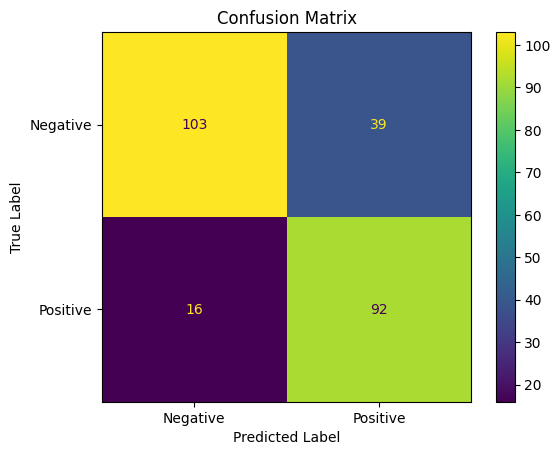

In [7]:
def build_easyModel():
    model = Sequential()
    model.add(Conv1D(filters=128, kernel_size=50, activation='relu', input_shape=(WS_B, 1)))
    #model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=128, kernel_size=10, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

model = build_easyModel()
model.summary()
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), verbose=1)

loss, accuracy = model.evaluate(X_test, y_test)

# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

f1 = f1_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))
plot_confusion_matrix(y_test, y_pred_binary)


# 3 CONVs

/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 751, 64)        │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 375, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 356, 128)       │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 178, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 169, 256)       │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 256)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 528,193 (2.01 MB)

 Trainable params: 528,193 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.5829 - loss: 0.7096 - val_accuracy: 0.6440 - val_loss: 0.6316
Epoch 2/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.6939 - loss: 0.5702 - val_accuracy: 0.7360 - val_loss: 0.5274
Epoch 3/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.7084 - loss: 0.5224 - val_accuracy: 0.7560 - val_loss: 0.5018
Epoch 4/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.7397 - loss: 0.4906 - val_accuracy: 0.7720 - val_loss: 0.4480
Epoch 5/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.7575 - loss: 0.4541 - val_accuracy: 0.7840 - val_loss: 0.4436
Epoch 6/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.7828 - loss: 0.4095 - val_accuracy: 0.8400 - val_loss: 0.3700
Epoch 7/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.8350 - loss: 0.3512 - val_accuracy: 0.7440 - val_loss: 0.4396
Epoch 8/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.8338 - loss: 0.3815 - val_accuracy: 0.848

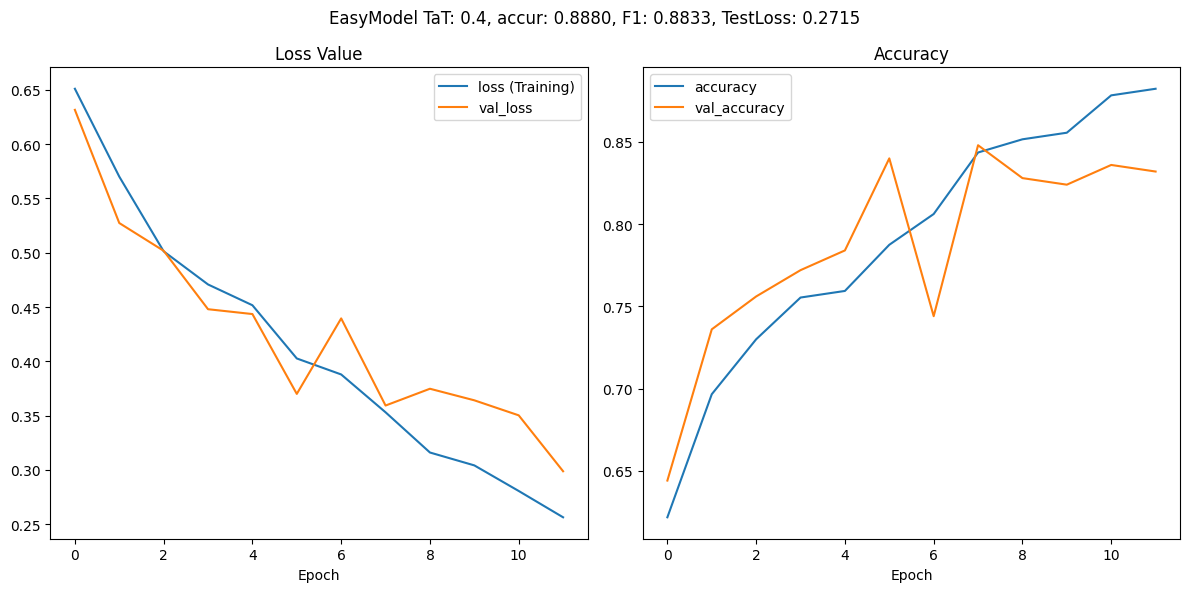

Train loss: 0.2564069926738739
Test val_loss: 0.2988055944442749
Train accuracy: 0.8823529481887817
Accuracy Score: 0.888
F1 Score: 0.8833333333333333
Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.82      0.89       142
         1.0       0.80      0.98      0.88       108

    accuracy                           0.89       250
   macro avg       0.89      0.90      0.89       250
weighted avg       0.91      0.89      0.89       250



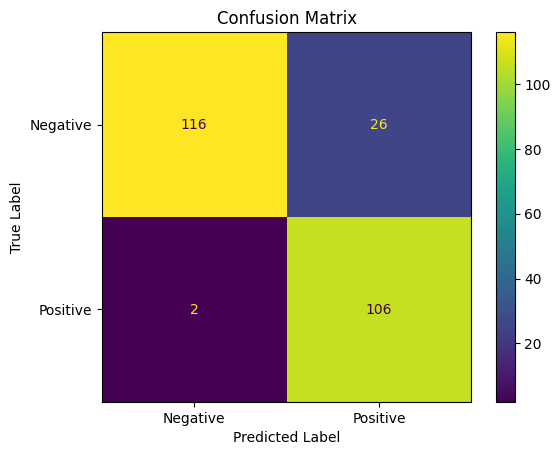

In [8]:
def build_easyModel():
    model = Sequential()
    model.add(Conv1D(64, kernel_size=50, activation='relu', input_shape=(WS_B, 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(128, kernel_size=20, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(256, kernel_size=10, activation='relu'))
    model.add(GlobalMaxPooling1D())
    #model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid')) # activation=(lambda x: x>0)

    return model

model = build_easyModel()
model.summary()
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_val, y_val), verbose=1)

loss, accuracy = model.evaluate(X_test, y_test)

# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

f1 = f1_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))
plot_confusion_matrix(y_test, y_pred_binary)


# 4 CONVs or Still "COMPLEX"

/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 701, 64)        │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 350, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 301, 128)       │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 301, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 292, 256)       │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 292, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 256)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 760,641 (2.90 MB)

 Trainable params: 760,641 (2.90 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/16
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step - accuracy: 0.5192 - loss: 0.8983 - val_accuracy: 0.5800 - val_loss: 0.7012
Epoch 2/16
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 180ms/step - accuracy: 0.5826 - loss: 0.6590 - val_accuracy: 0.6000 - val_loss: 0.6485
Epoch 3/16
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 180ms/step - accuracy: 0.6629 - loss: 0.6143 - val_accuracy: 0.6520 - val_loss: 0.6128
Epoch 4/16
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 210ms/step - accuracy: 0.6916 - loss: 0.5757 - val_accuracy: 0.7480 - val_loss: 0.5203
Epoch 5/16
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 187ms/step - accuracy: 0.7542 - loss: 0.4959 - val_accuracy: 0.7240 - val_loss: 0.5235
Epoch 6/16
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step - accuracy: 0.7535 - loss: 0.4877 - val_accuracy: 0.7560 - val_loss: 0.4894
Epoch 7/16
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 177ms/step - accuracy: 0.7435 - loss: 0.5276 - val_accuracy: 0.7400 - val_loss: 0.5110
Epoch 8/16
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - accuracy: 0.8016 - loss: 0.4529 - val_accuracy: 0.

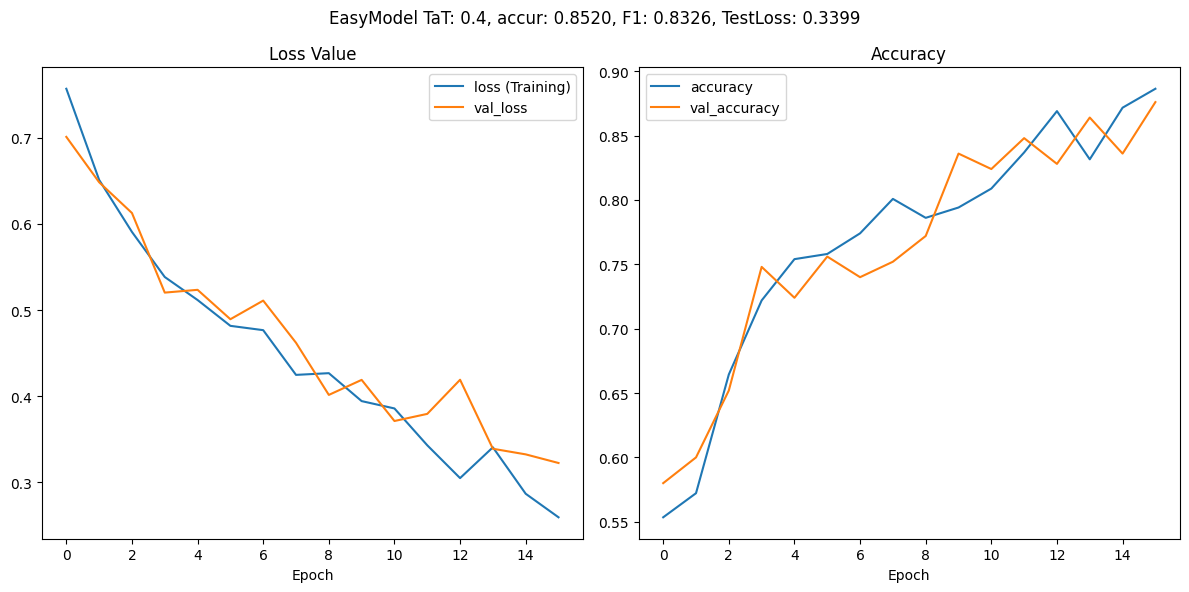

Train loss: 0.25920113921165466
Test val_loss: 0.3222913146018982
Train accuracy: 0.8863636255264282
Accuracy Score: 0.852
F1 Score: 0.832579185520362
Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.85      0.87       142
         1.0       0.81      0.85      0.83       108

    accuracy                           0.85       250
   macro avg       0.85      0.85      0.85       250
weighted avg       0.85      0.85      0.85       250



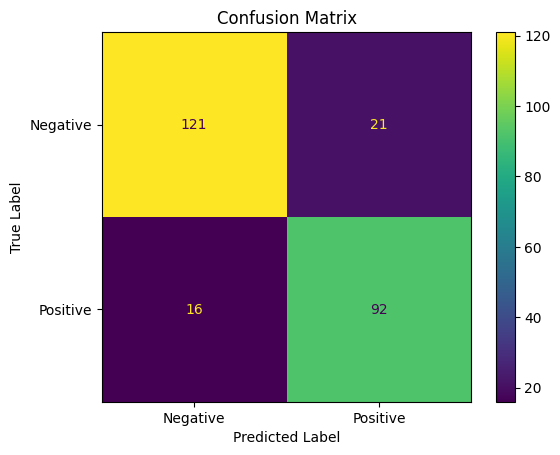

In [9]:
def build_easyModel():
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=100, activation='relu', input_shape=(WS_B, 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=128, kernel_size=50, activation='relu')) #LeakyReLU(alpha=0.001)
    model.add(Dropout(rate=0.1))
        
    model.add(Conv1D(filters=256, kernel_size=10, activation='relu'))
    model.add(Dropout(rate=0.1))
    
    # model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))

    model.add(GlobalMaxPooling1D())

    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

model = build_easyModel()
model.summary()
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=16, batch_size=32, validation_data=(X_val, y_val), verbose=1)

loss, accuracy = model.evaluate(X_test, y_test)

# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

f1 = f1_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))
plot_confusion_matrix(y_test, y_pred_binary)
